# Usando `scipy.integrate`

## Autores
Zach Pace, Lia Corrales, Stephanie T. Douglas

## Tradução

Luciano Cordeiro

## Objetivo do aprendizado
* realizar integração numérica no contexto `astropy` e científico python
 * aproximação trapezoidal
 * quadratura gaussiana
* usar as curvas de corpo negro embutidas do `astropy`
* entender como as unidades do `astropy` interagem umas com as outras
* definir uma classe Python
 * como funciona o método `__call__`
* adicionar rótulos $\LaTeX$ em figuras `matplotlib` usuando o formatador `latex_inline` 

## Palavras-chaves 
modelagem, unidades, synphot, OOP, LaTeX, astroestatística, matplotlib, física

## Conteúdo complementar
* http://synphot.readthedocs.io/en/latest/
* [Using Astropy Quantities for astrophysical calculations](http://www.astropy.org/astropy-tutorials/rst-tutorials/quantities.html)

## Sumário
Neste tutorial, usaremos os exemplos da função de Planck e da função de massa inicial estelar (IMF) para ilustrar como integrar numericamente, usando a aproximação trapezoidal e a quadratura gaussiana.  Também exploraremos a criação de uma classe personalizada, cuja instância pode ser chamada da mesma maneira que uma função.  Além disso, encontraremos as unidades integradas do astropy e teremos uma primeira amostra de como converter entre elas.  Finalmente, usaremos o $\LaTeX$ para facilitar a leitura dos rótulos dos eixos das figuras.

In [10]:
import numpy as np
from scipy import integrate
from astropy.modeling.models import BlackBody
from astropy import units as u, constants as c
import matplotlib.pyplot as plt

%matplotlib inline

## A função de Planck

A função de Planck descreve como um corpo negro irradia energia.  Vamos explorar como encontrar a luminosidade bolométrica usando a função de Planck tanto no espaço de frequência quanto no espaço de comprimento de onda.  

Digamos que temos um corpo negro a 5000 Kelvin.  Podemos descobrir a intensidade total (bolométrica) deste objeto, integrando a função de Planck. 
A maneira mais simples de fazer isso é aproximar a integral usando a regra do trapézio.

Vamos fazer isso primeiro usando a definição de frequência da função de Planck. Vamos definir uma grade de frequência de fótons e avaliar a função de Planck nessas frequências.  
 
Esses serão usados ​​para integrar numericamente usando a regra trapezoidal.  Ao multiplicar uma matriz `numpy` por uma unidade `astropy`, obtemos uma `quantidade`, que é efetivamente uma combinação de um ou mais números e uma unidade.

<div class="alert alert-info">
**Nota sobre unidades de impressão**: 

Quantidades e unidades podem ser impressas em strings usando [Format String Syntax](https://docs.python.org/3/library/string.html#format-string-syntax). Esta demonstração usa o formato `latex_inline` que está embutido no pacote 'astropy.units`.  Para ver formas adicionais de formatar quantidades, consulte [Getting Started](http://docs.astropy.org/en/stable/units/#getting-started) nas páginas de documentação do astropy.units.
</div>

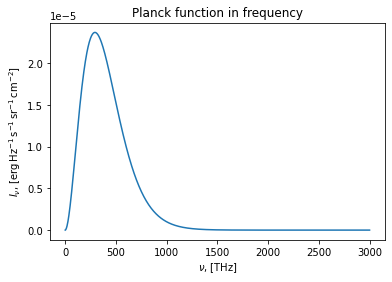

In [2]:
bb = BlackBody(5000. * u.Kelvin)

nu = np.linspace(1., 3000., 1000) * u.THz
bb5000K_nu = bb(nu)
plt.plot(nu, bb5000K_nu)
plt.xlabel(r'$\nu$, [{0:latex_inline}]'.format(nu.unit))
plt.ylabel(r'$I_{\nu}$, ' + '[{0:latex_inline}]'.format(bb5000K_nu.unit))
plt.title('Planck function in frequency')
plt.show()

### Usando $LaTeX$ para rotular eixos

Aqui, usamos a marcação $LaTeX$ para adicionar rótulos nos eixos com melhor aparência.  Para fazer isso, colocamos o texto de marcação LaTeX em cifrões, dentro de uma string `r'\$ ... \$'`. O `r` antes das aspas indica que a string é "raw" e as barras invertidas são tratadas literalmente.  Este é o formato sugerido para o texto do rótulo do eixo que inclui marcação. 

 Agora integramos numericamente usando a regra do trapézio.


In [3]:
np.trapz(x=nu, y=bb5000K_nu).to('erg s-1 cm-2 sr-1')

<Quantity 1.12808487e+10 erg / (cm2 s sr)>

Agora podemos fazer algo semelhante, mas para uma grade de comprimento de onda.  Queremos integrar em uma faixa de comprimento de onda equivalente à faixa de frequência que fizemos anteriormente.  Podemos transformar a frequência máxima no comprimento de onda (mínimo) correspondente usando o método `.to() `, com a adição de uma *equivalência*.

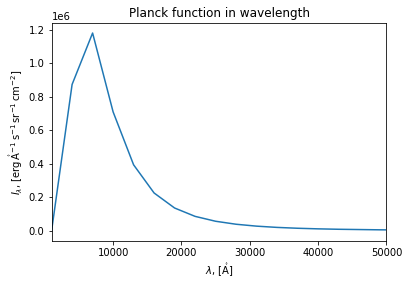

In [4]:
lam = np.linspace(nu.max().to(u.AA, equivalencies=u.spectral()),
                  nu.min().to(u.AA, equivalencies=u.spectral()), 1000)
bb_lam = BlackBody(bb.temperature, 
                   scale=1.0 * u.erg / (u.cm ** 2 * u.AA * u.s * u.sr))
bb5000K_lam = bb_lam(lam)
plt.plot(lam, bb5000K_lam)
plt.xlim([1.0e3, 5.0e4])
plt.xlabel(r'$\lambda$, [{0:latex_inline}]'.format(lam.unit))
plt.ylabel(r'$I_{\lambda}$, ' + '[{0:latex_inline}]'.format(bb5000K_lam.unit))
plt.title('Planck function in wavelength')
plt.show()

In [5]:
np.trapz(x=lam, y=bb5000K_lam).to('erg s-1 cm-2 sr-1')

<Quantity 1.14677601e+10 erg / (cm2 s sr)>

Observe que isso está dentro de alguns por cento da resposta que obtivemos no espaço de frequência, apesar de nossa amostragem ruim em pequenos comprimentos de onda!

Muitas funções `astropy` usam unidades e quantidades diretamente. À medida que você ganha confiança ao trabalhar com eles, considere incorporá-los ao seu fluxo de trabalho regular. Leia mais [aqui](http://docs.astropy.org/en/stable/units/) sobre como usar unidades.

###Como simular observações reais

Desde outono de 2017, o `astropy` não suporta explicitamente a construção de observações sintéticas de modelos como curvas de corpo negro. A [biblioteca synphot](https://synphot.readthedocs.io/en/latest/) permite isso. Você pode usar `synphot` para realizar tarefas como transformar espectros em magnitudes visuais por convolução com uma curva de filtro.

## A função de massa inicial estelar (IMF)

A função de massa inicial estelar nos diz quantas estrelas de cada massa são formadas. Em particular, as estrelas de baixa massa são muito mais abundantes do que as estrelas de alta massa. Vamos explorar mais a funcionalidade do `astropy` usando esta ideia.

As pessoas geralmente pensam no FMI como uma função de densidade de probabilidade de lei de potência. Em outras palavras, se você contar as estrelas que nasceram recentemente de uma nuvem de gás, sua distribuição de massas seguirá o FMI. Vamos escrever uma pequena classe para nos ajudar a acompanhar isso:

In [6]:
class PowerLawPDF(object):
    def __init__(self, gamma, B=1.):
        self.gamma = gamma
        self.B = B
    def __call__(self, x):
        return x**self.gamma / self.B

### O método `__call__` 

Ao definir o método `__call__`, estamos dizendo ao interpretador Python que uma instância da classe pode ser chamada como uma função. Quando chamada, uma instância desta classe recebe um único argumento, `x`, mas usa outros atributos da instância, como `gamma` e `B`.

### Mais sobre as aulas

As classes são estruturas de dados mais avançadas, que podem ajudá-lo a acompanhar a funcionalidade em seu código que funciona em conjunto. Você pode aprender mais sobre aulas neste [tutorial](https://www.codecademy.com/ja/courses/learn-python/lessons/introduction-to-classes/exercises/why-use-classes).

## Integração usando quadratura gaussiana

Nesta seção, exploraremos um método de integração numérica que não requer já ter sua grade de amostragem configurada. `scipy.integrate.quad` com referência [aqui](https://docs.scipy.org/doc/scipy-0.19.1/reference/generated/scipy.integrate.quad.html) recebe uma função e um valor menor e limite superior, e nossa classe `PowerLawPDF` cuida disso muito bem.

Agora podemos usar nossa nova classe para normalizar nosso IMF dados os limites de massa. Isso equivale a normalizar uma função de densidade de probabilidade. Usaremos a quadratura gaussiana (`quad`) para encontrar a integral. `quad` retorna o valor numérico da integral e sua incerteza. Nós só nos importamos com o valor numérico, então vamos empacotar a incerteza em `_` (uma variável de espaço reservado). Nós imediatamente jogamos a integral em nosso objeto IMF e a usamos para normalizar!

Para ler mais sobre *empacotamento e desempacotamento generalizado* em Python, veja a proposta original, [PEP 448](https://www.python.org/dev/peps/pep-0448/), que foi aceita em 2015.

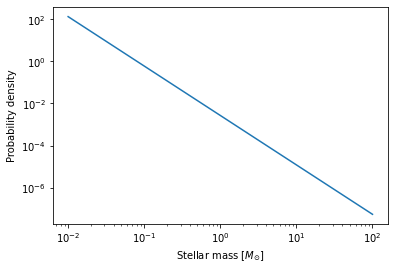

In [7]:
salpeter = PowerLawPDF(gamma=-2.35)
salpeter.B, _ = integrate.quad(salpeter, a=0.01, b=100.)

m_grid = np.logspace(-2., 2., 100)
plt.loglog(m_grid, salpeter(m_grid))
plt.xlabel(r'Stellar mass [$M_{\odot}$]')
plt.ylabel('Probability density')
plt.show()

### Quantas estrelas M existem a mais do que estrelas O?

Vamos comparar o número de estrelas anãs M (massa inferior a 60% solar) criadas pelo FMI, com o número de estrelas O (massa superior a 15 vezes solar).

In [8]:
n_m, _ = integrate.quad(salpeter, a=.01, b=.6)
n_o, _ = integrate.quad(salpeter, a=15., b=100.)
print(n_m / n_o)

20936.017868337385


Existem quase 21.000 estrelas de baixa massa nascidas do que estrelas de alta massa!

### Onde está toda a massa?

Agora vamos calcular as massas totais relativas para todas as estrelas O e todas as estrelas M nascidas. Para fazer isso, pondere o Salpeter IMF em massa (ou seja, adicione um fator extra de massa à integral). Para fazer isso, definimos uma nova função que toma a velha lei de potência IMF como um de seus argumentos. Como esse argumento não é alterado em toda a integral, ele é passado para a tupla `args` dentro de `quad`. É importante que haja apenas *um* argumento que mude sobre a integral, e que seja o *primeiro* argumento que a função que está sendo integrada aceita.

Matematicamente, a integral para as estrelas M é

$$ m^M = \int_{.01 \, M_{\odot}}^{.6 \, M_{\odot}} m \, {\rm IMF}(m) \, dm $$

e equivale a ponderar a função densidade de probabilidade (o FMI) em massa. De maneira mais geral, você encontra o valor de alguma propriedade $\rho$ que depende de $m$ calculando

$$ \rho(m)^M = \int_{.01 \, M_{\odot}}^{.6 \, M_{\odot}} \rho(m) \, {\rm IMF}(m) \, dm $$

In [9]:
def IMF_m(m, imf):
    return imf(m) * m

m_m, _ = integrate.quad(IMF_m, a=.01, b=.6, args=(salpeter, ))
m_o, _ = integrate.quad(IMF_m, a=15., b=100., args=(salpeter, ))

m_m / m_o

20.29197629920483



Assim, cerca de 20 vezes mais massa está ligada em estrelas M do que em estrelas O.

### Extras

* Agora compare a luminosidade total de todas as estrelas O com a luminosidade total de todas as estrelas M. Isso requer uma relação massa-luminosidade, como esta que você usará como $\rho(m)$:

$$
 \frac{L}{L_{\odot}} (M) =
  \begin{cases} 
      \hfill .23 \left( \frac{M}{M_{\odot}} \right)^{2.3} \hfill , \hfill & .1 < \frac{M}{M_{\odot}} < .43 \\
      \hfill \left( \frac{M}{M_{\odot}} \right)^{4} \hfill , \hfill & .43 < \frac{M}{M_{\odot}} < 2 \\
      \hfill 1.5 \left( \frac{M}{M_{\odot}} \right)^{3.5} \hfill , \hfill & 2 < \frac{M}{M_{\odot}} < 20 \\
      \hfill 3200 \left( \frac{M}{M_{\odot}} \right) \hfill , \hfill & 20 < \frac{M}{M_{\odot}} < 100 \\
  \end{cases},
$$

* Pense em quais estrelas estão produzindo a maior parte da luz e quais estrelas têm a maior parte da massa. Como isso pode resultar em dificuldade em inferir massas estelares a partir da luz que elas produzem? Se estiver interessado em saber mais, consulte este [artigo de revisão](https://ned.ipac.caltech.edu/level5/Sept14/Courteau/Courteau_contents.html).

## Problema desafiador

* No momento, não estamos preocupados com os limites da lei de potência, mas o FMI deve cair para zero de probabilidade em massas abaixo de 0,01 massas solares e acima de 100 massas solares. Modifique `PowerLawPDF` de uma forma que permita entradas `float` e `numpy.ndarray`.
* Modifique a classe `PowerLawPDF` para usar explicitamente as construções `units` do `astropy`.
* Deduza uma relação entre a taxa de formação de estrelas recente e a luminosidade de $H\alpha$. Em outras palavras, encontre um valor de $C$ para a função

$${\rm SFR \, [\frac{M_{\odot}}{yr}]} = {\rm C \, L_{H\alpha} \, [\frac{erg}{s}]} \, .$$

* Como isso depende da inclinação e dos pontos finais do FMI?
* Dê uma olhada no Apêndice B de [Hunter & Elmegreen 2004, AJ, 128, 2170](http://adsabs.harvard.edu/cgi-bin/bib_query?arXiv:astro-ph/0408229)
* Que efeito a alteração do índice da lei de potência ou do limite de massa superior do FMI tem sobre o valor de $C$?
* Preveja o efeito sobre o valor de $C$ de usar uma forma diferente do FMI, como Kroupa ou Chabrier (ambos são mais leves na extremidade de baixa massa).
* Se você ainda não está cansado de IMFs, tente definir uma nova classe que implemente uma IMF de lei de potência quebrada (Kroupa) ou log-parabola (Chabrier). Faça os mesmos cálculos acima.